# Model selection
I chose SVD (Singular Value Decomposition) over KNN (K-Nearest Neighbors) because SVD handles data sparsity more effectively and is more efficient with smaller datasets, like the one we have. KNN can be slow and prone to overfitting with limited data, as it requires comparing each point with others, which isn’t ideal in our case. Additionally, SVD reduces the dimensionality of the user-product matrix, capturing latent patterns to make more accurate recommendations. It also offers better generalization, especially in sparse data scenarios, leading to improved recommendation quality, particularly for the first recommendations, which are the most important in this model



### Feature Exploration
We also need to analyze how the features are summarized to improve the model in future iterations. From this, we can observe that the features most related to each other are quantity, subtotal, amount_total, and amount_tax. They are closely linked, as they essentially represent similar values. This suggests that we could eliminate two of these features without losing significant information. Additionally, many other features were not selected in the model, indicating that they might not be as relevant.

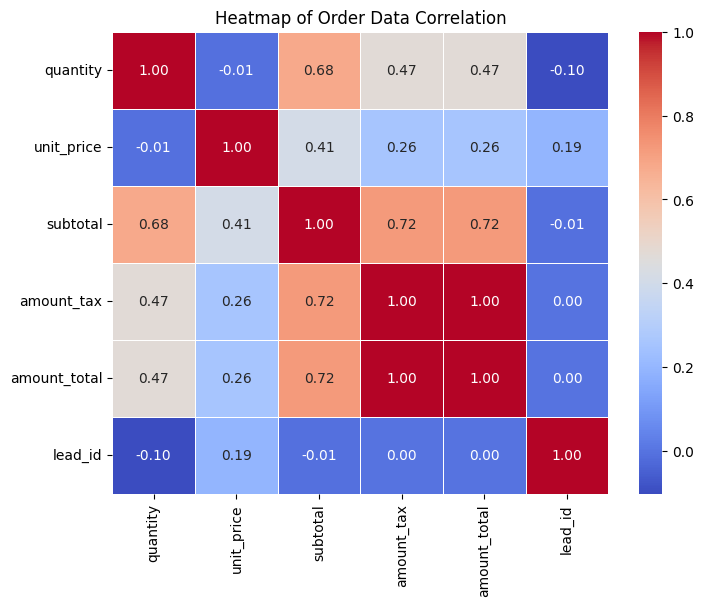

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np

order_data = pd.read_parquet("../data/processed/order_data.parquet")

numeric_data = order_data[['quantity', 'unit_price', 'subtotal', 'amount_tax', 'amount_total', 'lead_id']]

correlation_matrix = numeric_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Order Data Correlation')
plt.show()


We can use decision trees to select the most important features for the model. The decision tree evaluates the importance of each feature by splitting the data optimally at each iteration. At the end of the process, it generates a ranking that highlights which features have the most significant impact on the model's performance. As we can see from the substantial reduction, features 1, 7, 5, and 0 are the most important.

However, even though these are the top features, that doesn’t mean the others are irrelevant. Some of them may still be valuable and could potentially be selected and combined, especially if they are derived from a model like SVD, to create new features that could further enhance the model.

In [11]:
import numpy as np
import pickle
import pandas as pd
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.tree import DecisionTreeRegressor

with open("../models/collaborative_filtering/svd_model.pkl", "rb") as f:
    U, Sigma, Vt = pickle.load(f)

user_product_matrix = order_data.pivot_table(index='partner_invoice', 
                                             columns='product_name', 
                                             values='quantity', 
                                             aggfunc='sum', 
                                             fill_value=0)

Sigma_matrix = np.diag(Sigma)

predictions = np.dot(np.dot(U, Sigma_matrix), Vt)

predicted_ratings_df = pd.DataFrame(predictions, 
                                    columns=user_product_matrix.columns, 
                                    index=user_product_matrix.index)

num_users, num_products = U.shape[0], Vt.shape[1]

X_train = []
y_train = []

for user_idx in range(num_users):
    for product_idx in range(num_products):
        user_factors = U[user_idx]  
        product_factors = Vt[:, product_idx]  
        rating_pred = predicted_ratings_df.iloc[user_idx, product_idx] 

        X_train.append(np.hstack([user_factors, product_factors]))
        y_train.append(rating_pred)  

X_train = np.array(X_train)
y_train = np.array(y_train)

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)
print(tree.get_depth())

perm = PermutationImportance(tree, random_state=42).fit(X_train, y_train)


eli5.show_weights(perm)





11


Weight,Feature
1.0270 ± 0.2888,x1
1.0021 ± 0.1176,x7
0.9361 ± 0.3719,x0
0.7740 ± 0.3215,x5
0.4068 ± 0.3137,x6
0.3796 ± 0.2098,x3
0.2486 ± 0.1479,x2
0.1906 ± 0.0953,x9
0.1265 ± 0.0648,x4
0.0118 ± 0.0034,x8


Here we can see a more detailed graph of these features.

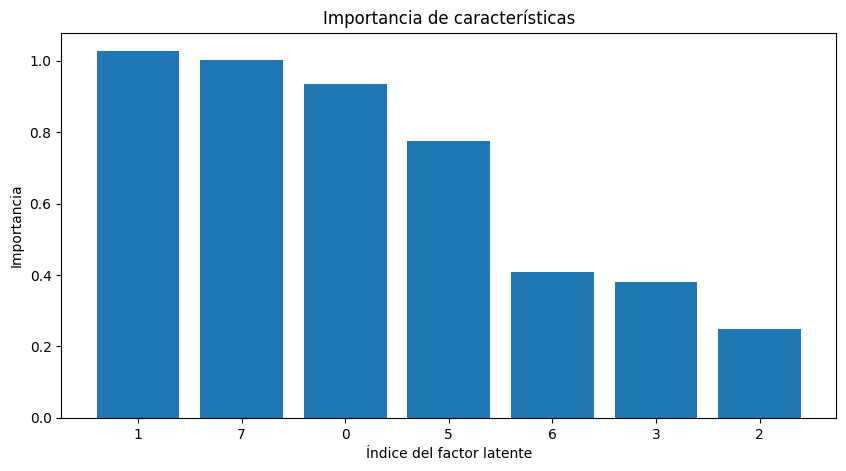

In [12]:
import numpy as np
import matplotlib.pyplot as plt

importances = perm.feature_importances_
indices = np.argsort(importances)[::-1]  

plt.figure(figsize=(10, 5))
plt.title("Importancia de características")
plt.bar(range(7), importances[indices[:7]], align="center")
plt.xticks(range(7), indices[:7])
plt.xlabel("Índice del factor latente")
plt.ylabel("Importancia")
plt.show()


#### Thanks for reading